#  Image segmentation for detecting brain tumor

In the previous kernel I made a CNN model to classify if a brain has tumor or not. The accuracy of the model was really good. But in this kernel I am going to use Image segmentation by U-net CNN model to determain the brain's tumor in yes cases.

*** My analysis take the following steps:**

1- Making Mask

2- Preparing data

3- Building U-net CNN model


4- Training the model

5-Evalutation Model on some training data


6-Evaluation model on the test data



# Step 1: Making Masks

**What is mask? **

Image segmentation creates a pixel-wise mask for each object in the image. This technique gives us a far more granular understanding of the object(s) in the image.

[![enter image description here][1]][1]

  [1]: https://i.stack.imgur.com/sXrwS.jpg

In the rigth photo, each item bounded in red,blue and green curves is called a mask. Image segmentation creates a pixel-wise mask for each object in the image.

In this project tumors in yes images are masks.

**How to create masks for our train data set?**

There are many ways to make masks for a data set. You can find many Github sources. In this project I used labelbox. Labelbox is a very powerfull software for making masks. I uploudes masks for all train data. You can find them in the train folder. (Note that I don't have medical background so masks migth not be quite exact).


Lets look at some masks and images:

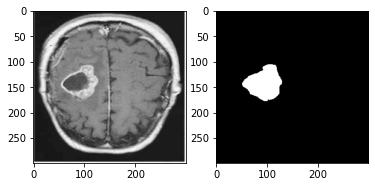

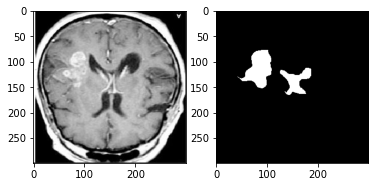

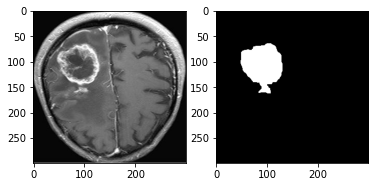

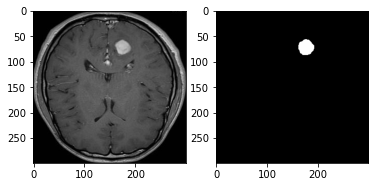

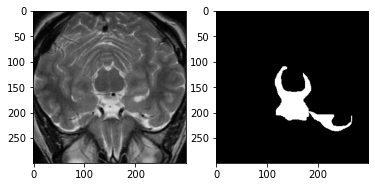

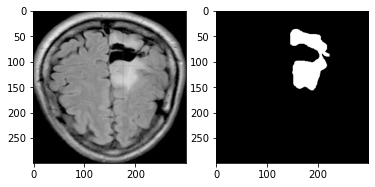

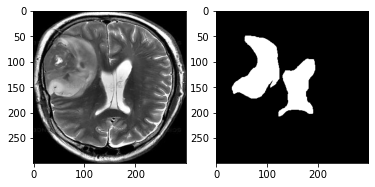

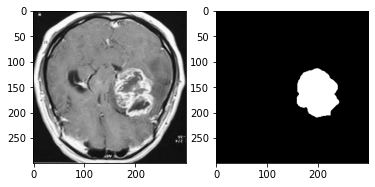

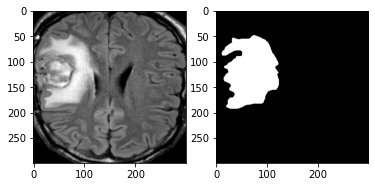

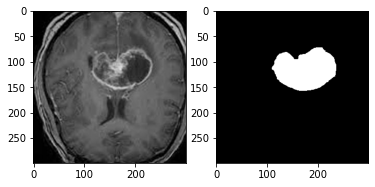

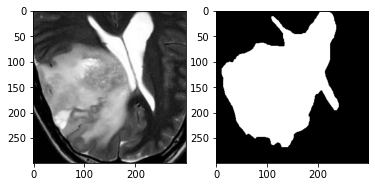

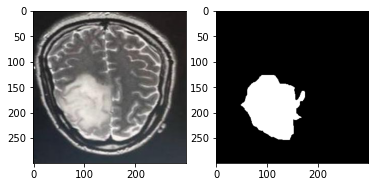

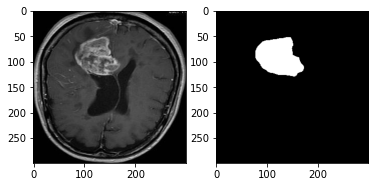

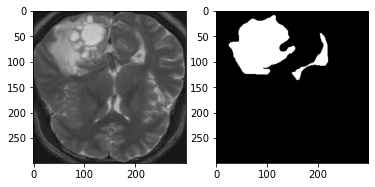

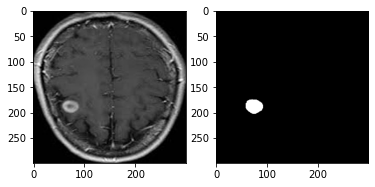

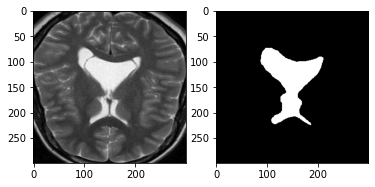

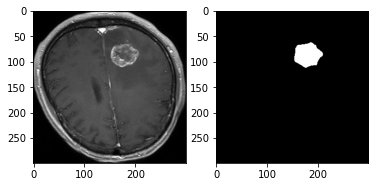

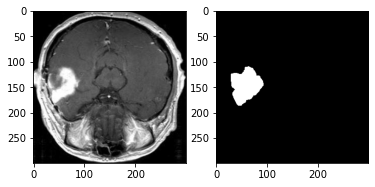

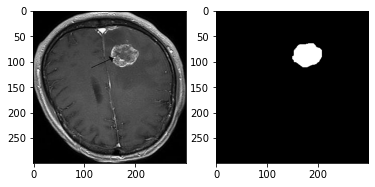

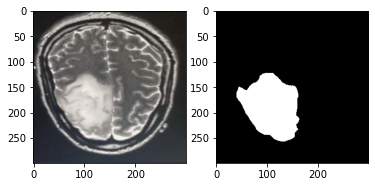

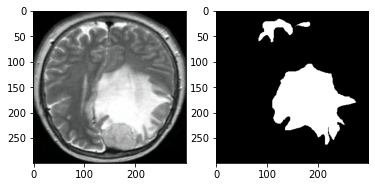

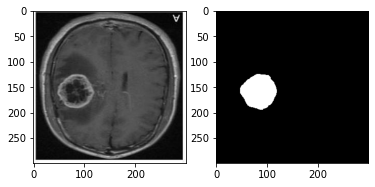

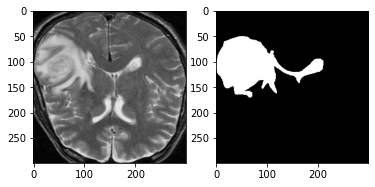

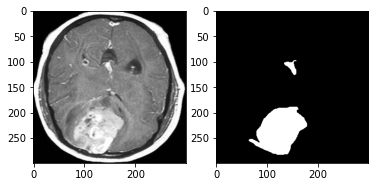

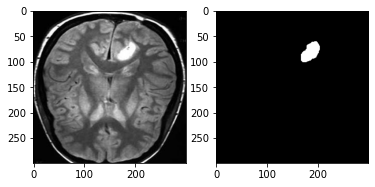

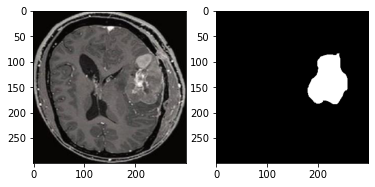

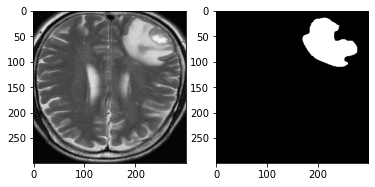

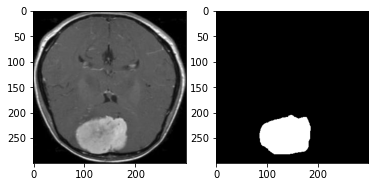

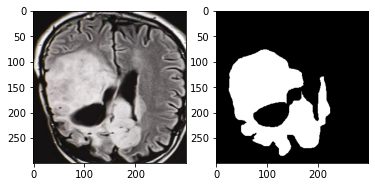

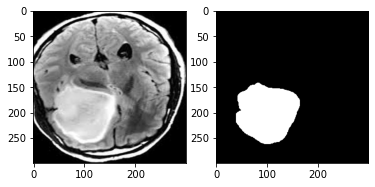

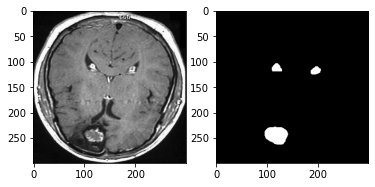

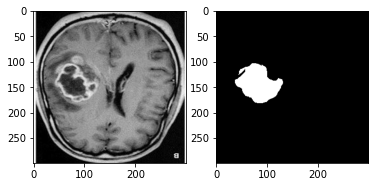

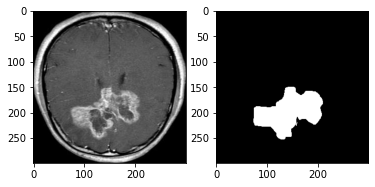

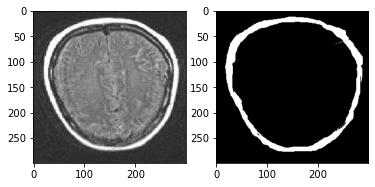

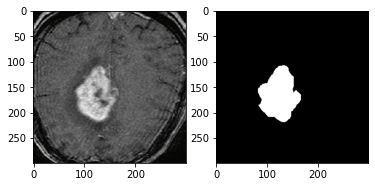

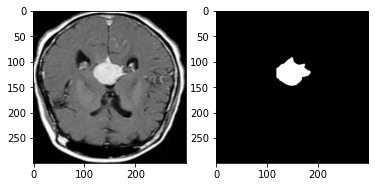

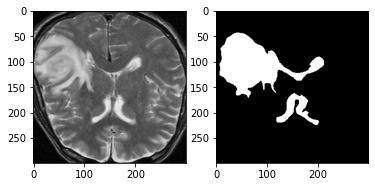

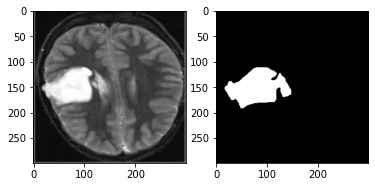

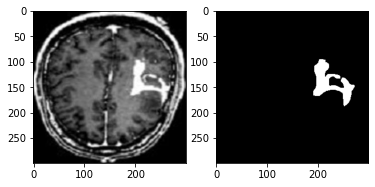

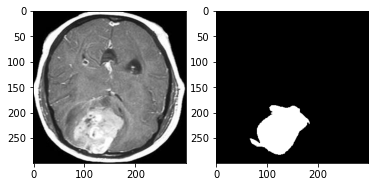

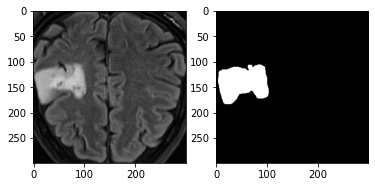

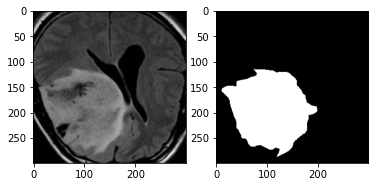

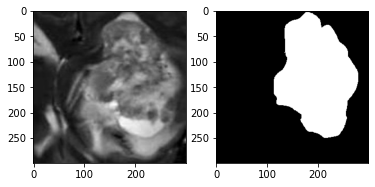

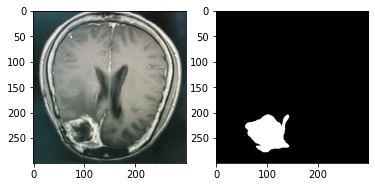

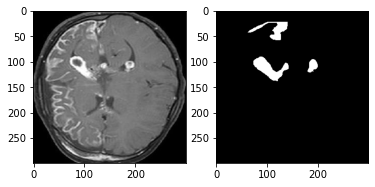

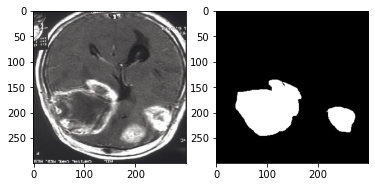

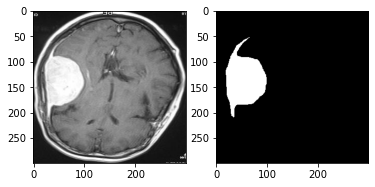

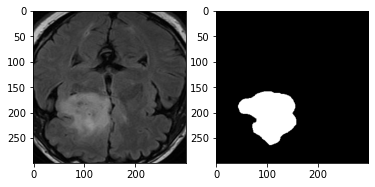

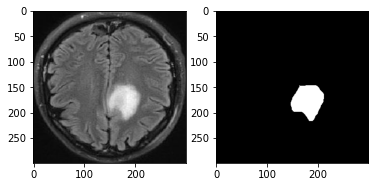

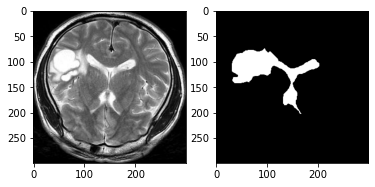

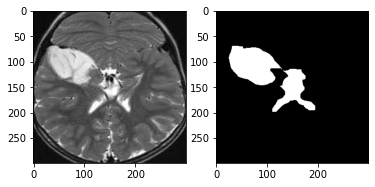

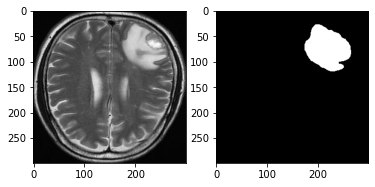

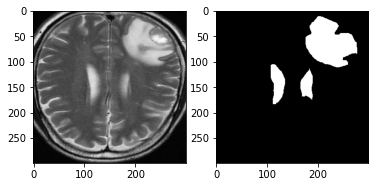

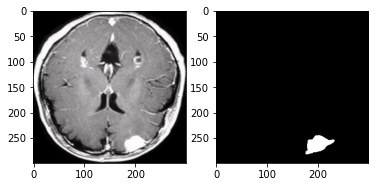

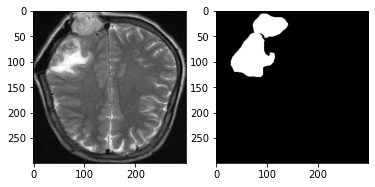

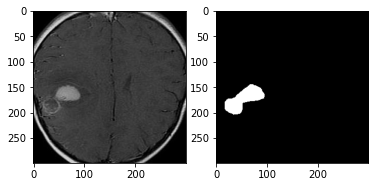

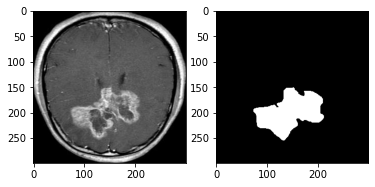

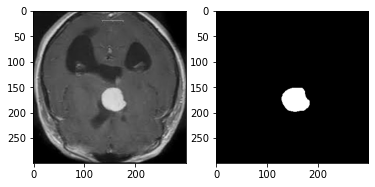

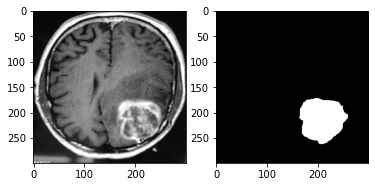

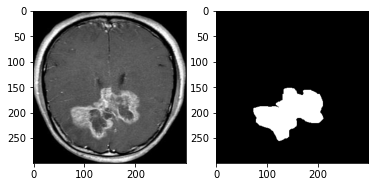

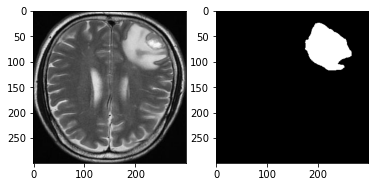

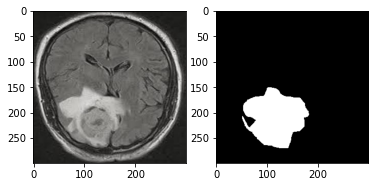

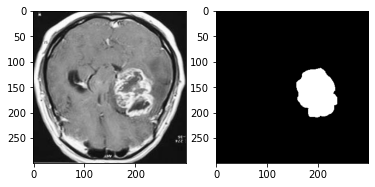

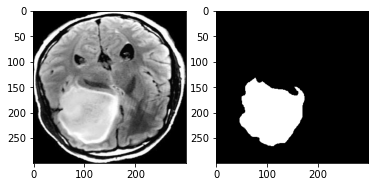

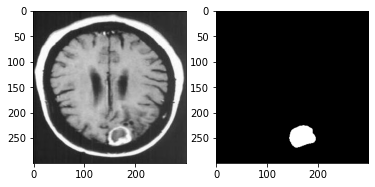

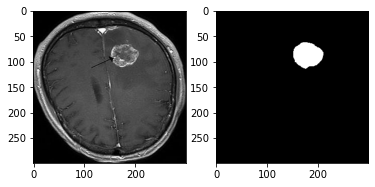

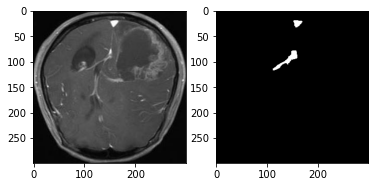

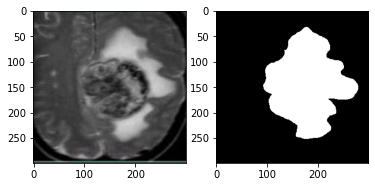

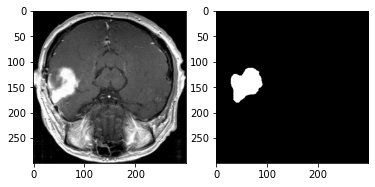

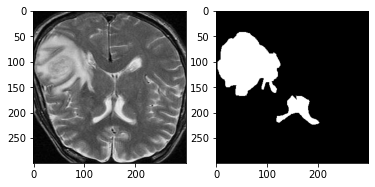

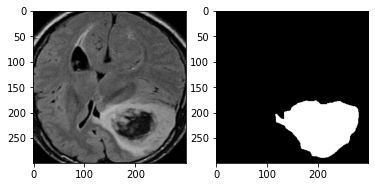

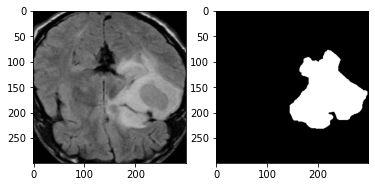

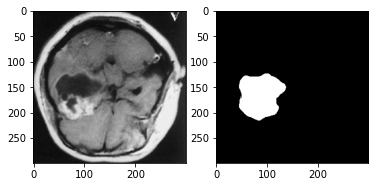

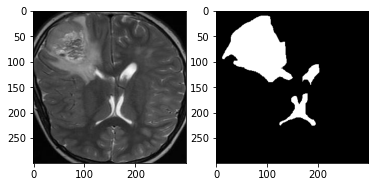

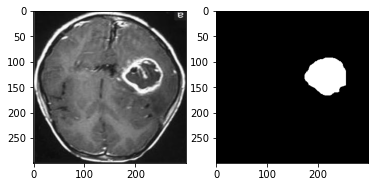

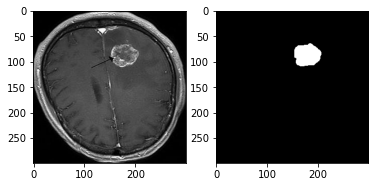

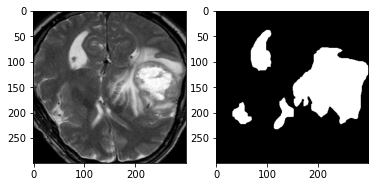

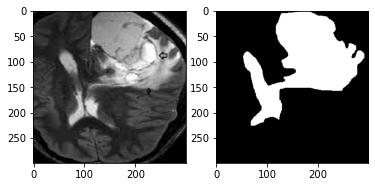

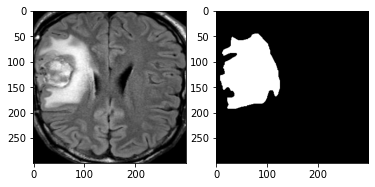

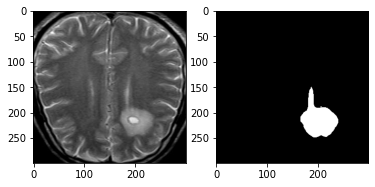

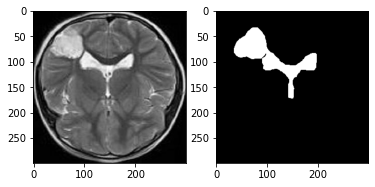

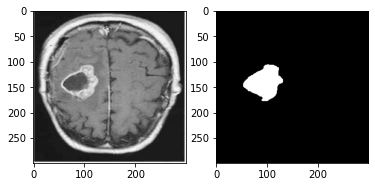

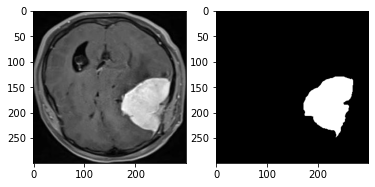

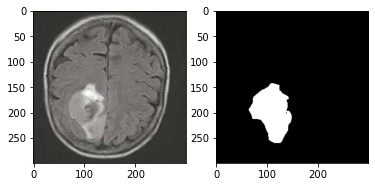

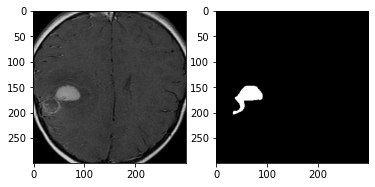

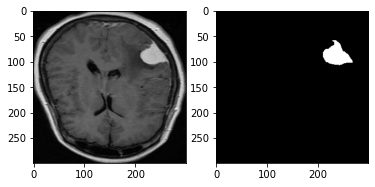

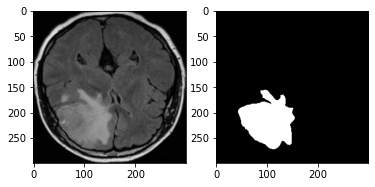

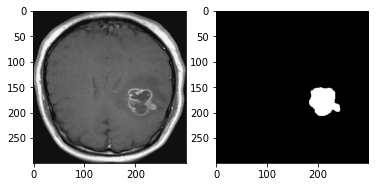

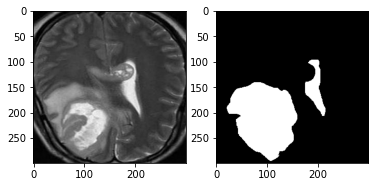

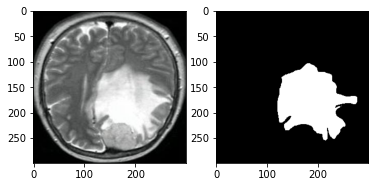

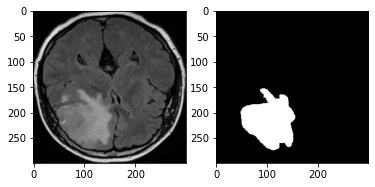

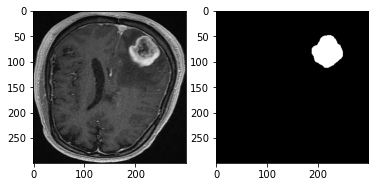

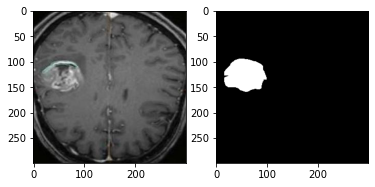

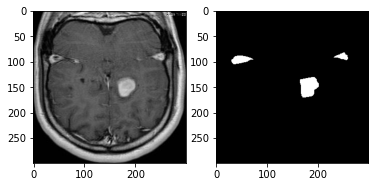

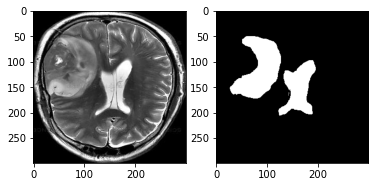

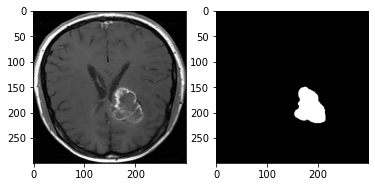

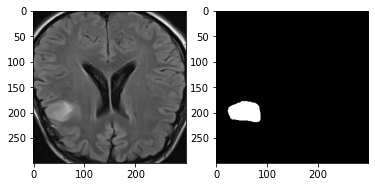

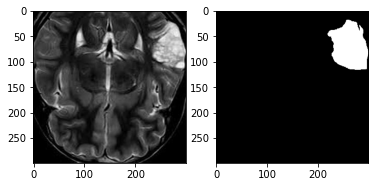

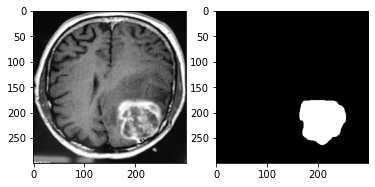

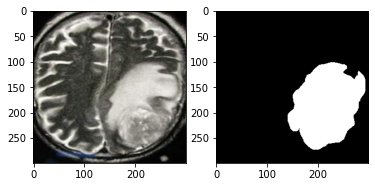

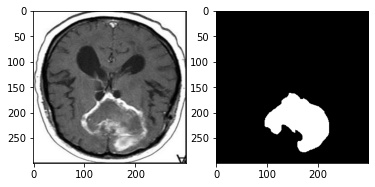

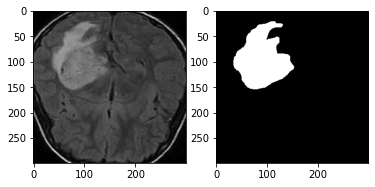

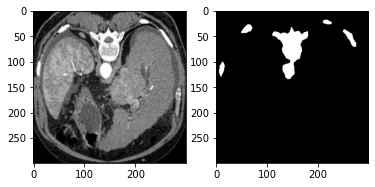

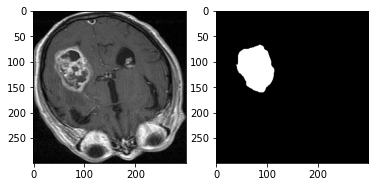

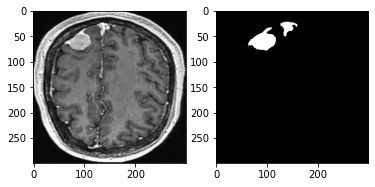

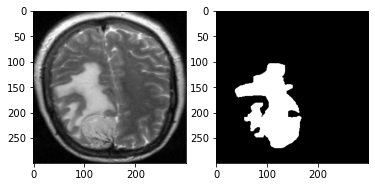

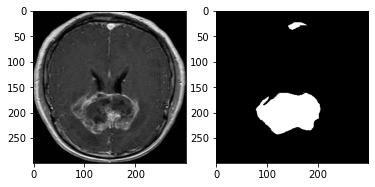

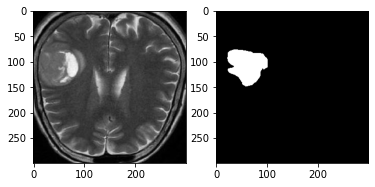

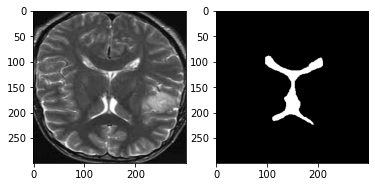

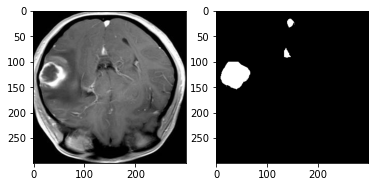

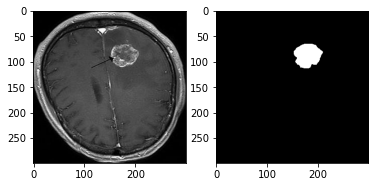

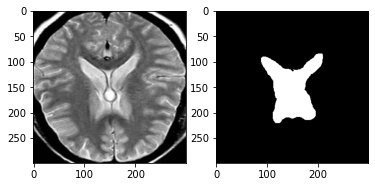

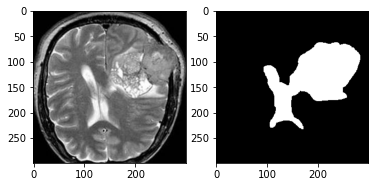

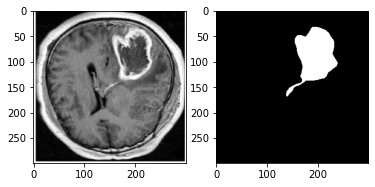

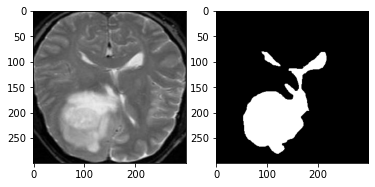

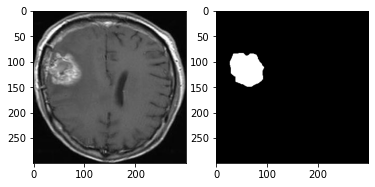

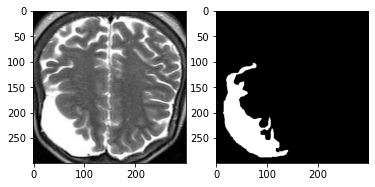

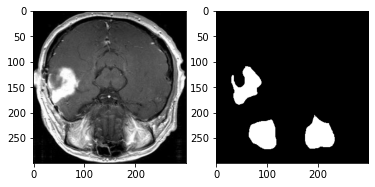

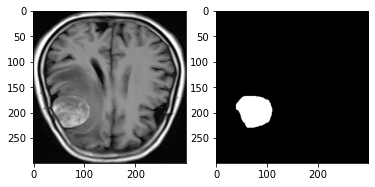

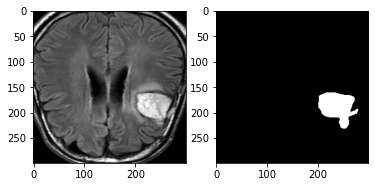

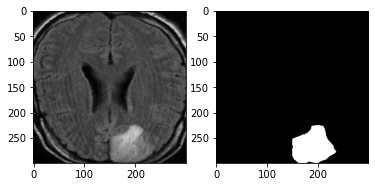

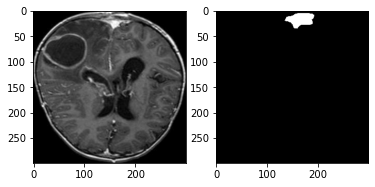

In [ ]:
import os
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np

TRAIN_PATH='../input/training-data-and-masks/train/'
train_ids = next(os.walk(TRAIN_PATH))[1]
for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = plt.imread(path + '/images/' + id_ )[:,:,:3]
    img1 = plt.imread(path + '/masks/' + id_ )[:,:,:3]
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.rot90(img,2))
    f.add_subplot(1,2, 2)
    plt.imshow(np.rot90(img1,2))
    plt.show(block=True)


In [ ]:
f, axarr

# Step 2: Preparing Data

In [ ]:
from tqdm import tqdm
from skimage.transform import resize
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = plt.imread(path + '/images/' + id_ )[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = plt.imread(path + '/masks/' + id_)[:,:,:1]
    mask=resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

print('Done')

Getting and resizing training images ... 


100%|██████████| 122/122 [00:02<00:00, 49.09it/s]

Done


Let's look at images and masks after preparation

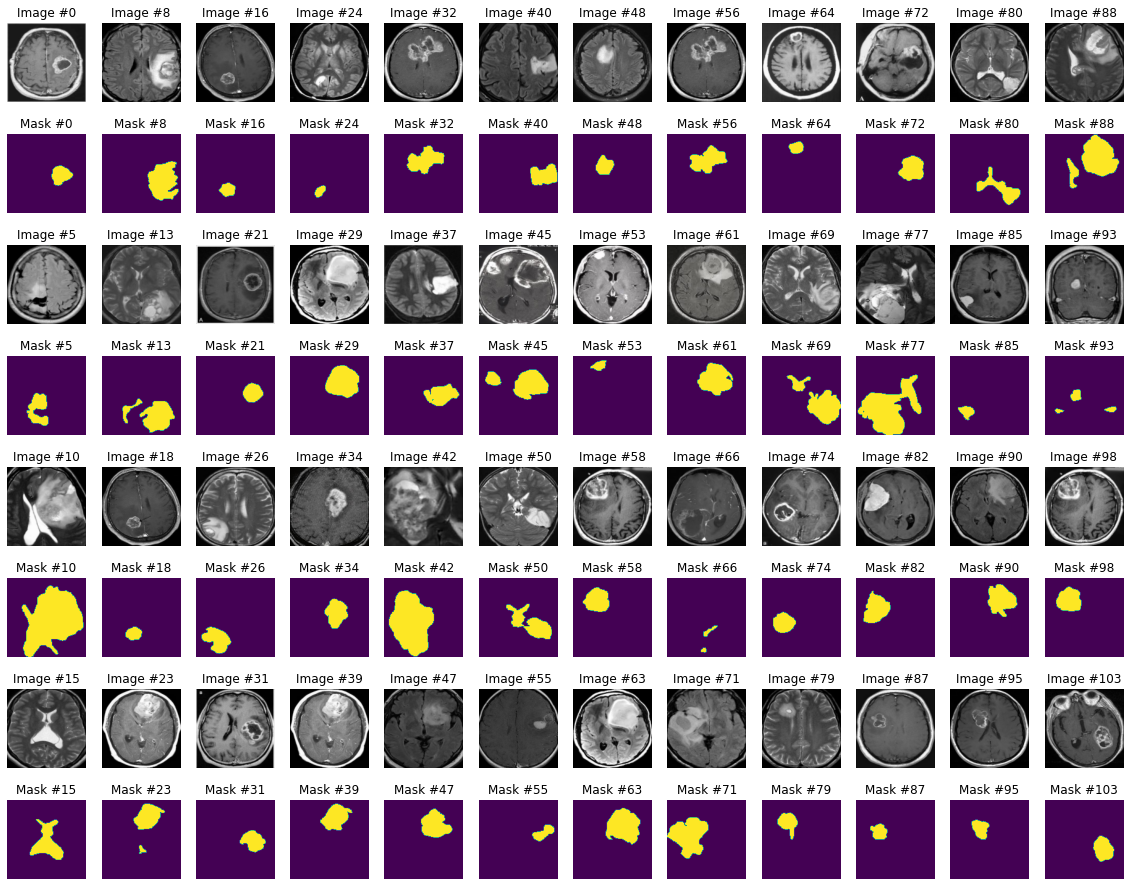

In [ ]:
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*5 + j*8
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)

        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))

        plt.axis('off')

plt.show()

# Step 3: Building U-net CNN Model

**What is u-net CNN model?**

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

**Why we call it U-net network? **

The reason behind why it is named U-Net is because of the shape of its architecture, which is the letter “U”. The architecture contains two paths. The left part of the letter “U” is called an encoder and the right part is called a decoder.

**What is encoder and decoder?**

The encoder is the first half in the architecture diagram (Figure below). It usually is a pre-trained classification network like VGG/ResNet where you apply convolution blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

The decoder is the second half of the architecture. The goal is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations.

[![enter image description here][1]][1]


  [1]: https://i.stack.imgur.com/hMQjJ.png

What is encoder and decoder?

In [ ]:
import sys
import random
import warnings #
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

**Building U-net CNN**


In [ ]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 128, 128, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 128, 128, 16) 448         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 128, 128, 16) 0           conv2d_171[0][0]                 
______________________________________________________________________________________

# Trading the model

In [ ]:
!pip install tensorflow-gpu==1.14.0

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

2.3.1


False

In [ ]:
tf.compat.v1.disable_eager_execution()
model_path = "nuclei_finder_unet_1.h5"
# Initialize our callbacks

checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=10,callbacks=[earlystop, checkpoint])



Train on 109 samples, validate on 13 samples
Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8667
Epoch 00001: val_loss improved from inf to 0.29573, saving model to nuclei_finder_unet_1.h5
109/109 [==============================] - 16s 148ms/sample - loss: 0.4480 - accuracy: 0.8667 - val_loss: 0.2957 - val_accuracy: 0.9193
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.9038
Epoch 00002: val_loss improved from 0.29573 to 0.20947, saving model to nuclei_finder_unet_1.h5
109/109 [==============================] - 10s 88ms/sample - loss: 0.3129 - accuracy: 0.9038 - val_loss: 0.2095 - val_accuracy: 0.9235
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9110
Epoch 00003: val_loss improved from 0.20947 to 0.18851, saving model to nuclei_finder_unet_1.h5
109/109 [==============================] - 10s 91ms/sample - loss: 0.2465 - accuracy: 0.9110 - val_loss: 0.1885 

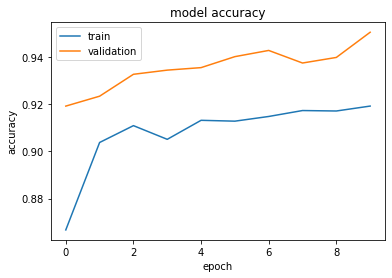

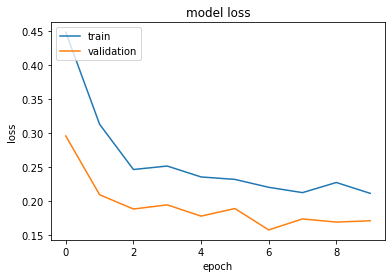

In [ ]:
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # "Loss"
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Evaluation of the Model

First let's look at the traing data evaluation

In [ ]:
model = load_model('nuclei_finder_unet_1.h5',
                   custom_objects={'my_iou_metric': my_iou_metric})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)


#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)


Showing the evalution of the data on the training set

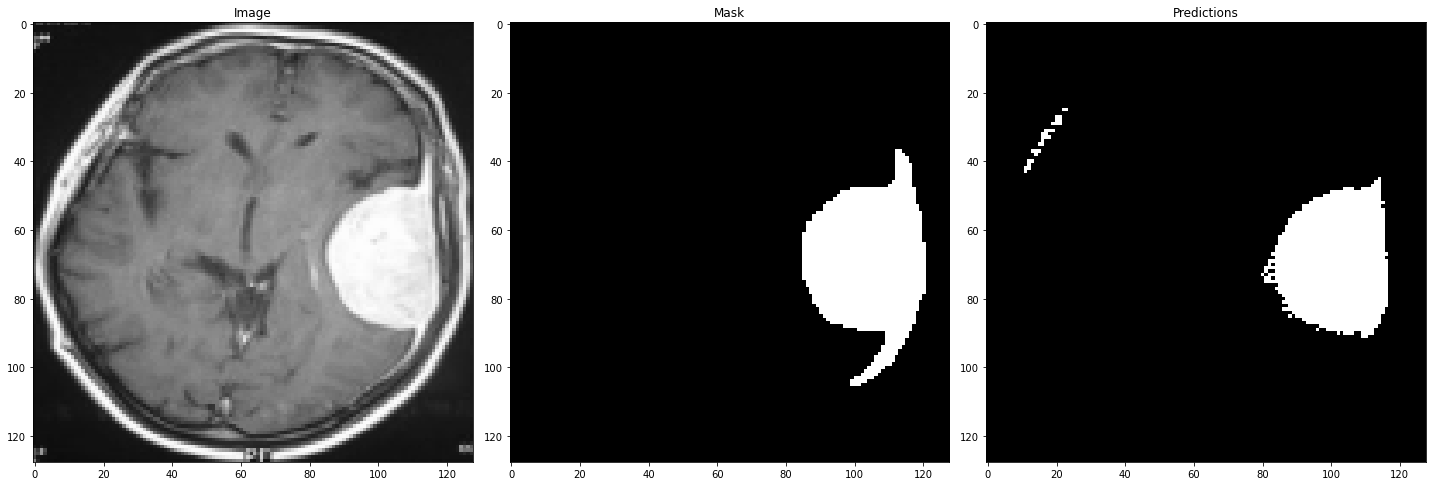

In [ ]:
# Ploting our predicted masks
ix = random.randint(0, 120)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

# Evaluation of the model on the test data

Now let's evalute the model on the test data. First we read test images from testData folder.

In [ ]:
import os
import cv2
import numpy as np
data=[]
for dirname, _, filenames in os.walk('../input/testdata/test'):
    for filename in filenames:
        img=cv2.imread(os.path.join(dirname, filename))
        img=cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        if img is not None:
                data.append(img)

data1=np.array(data)


prediction of the test data:

In [ ]:
preds_test = model.predict(data1, verbose=1)


#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_train > 0.5).astype(np.uint8)

Evaluating test data

In [ ]:
preds_test = model.predict(data1, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

Showing the evalation result

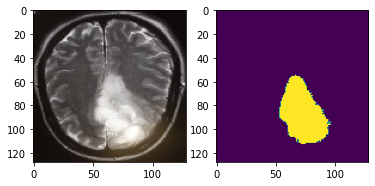

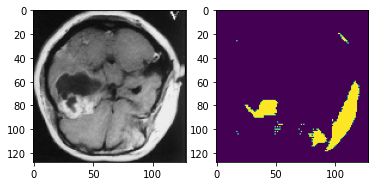

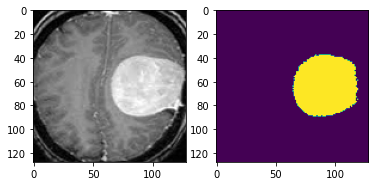

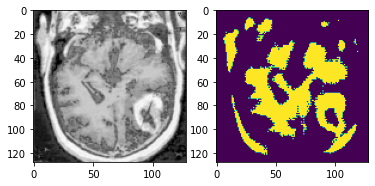

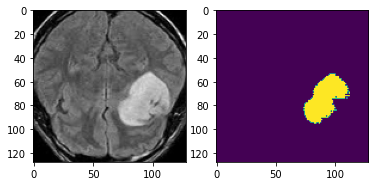

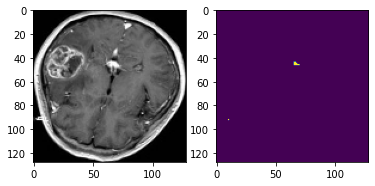

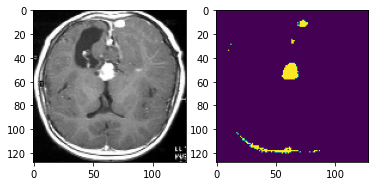

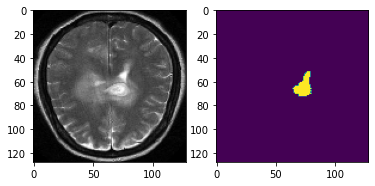

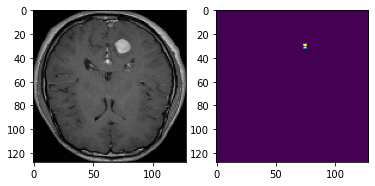

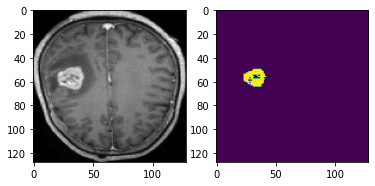

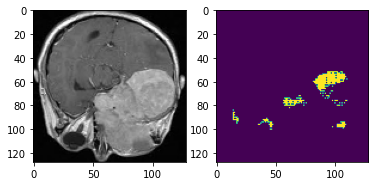

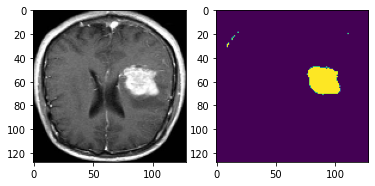

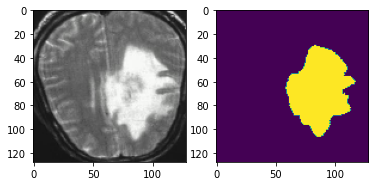

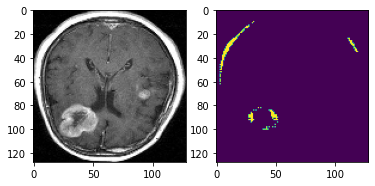

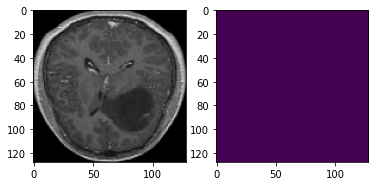

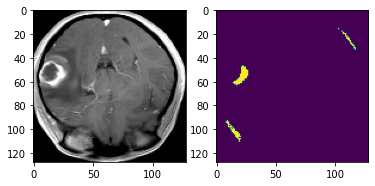

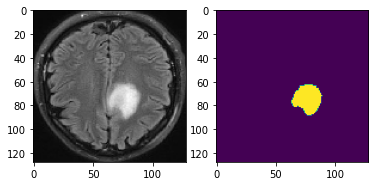

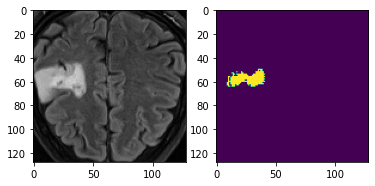

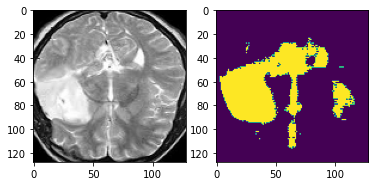

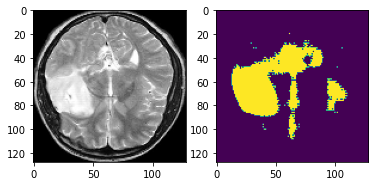

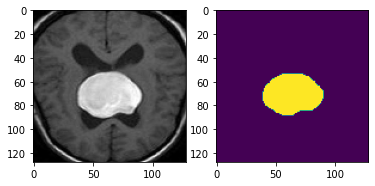

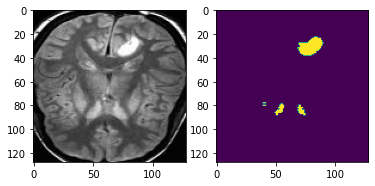

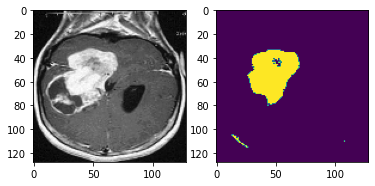

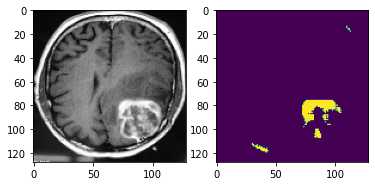

In [ ]:
for n in range(len(data)):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.rot90(data[n],2))
    f.add_subplot(1,2, 2)
    plt.imshow(np.rot90(np.squeeze(preds_test_t[n]),2))
    plt.show(block=True)

# Conclusion:
    
In this project I used U-net CNN for Image segmentation of brain tumor. The result is good on the test data but it can be better by improving the model. For example creating accuracy function.